In [112]:
# Import libraries
import os
import pandas as pd
import numpy as np
import scipy.stats as st
from scipy.stats import zscore
import seaborn as sns
import plotly.express as px
from copy import deepcopy
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from feature_engine.selection import DropDuplicateFeatures, DropConstantFeatures, DropCorrelatedFeatures, RecursiveFeatureElimination
import xgboost as xg
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [113]:
current_directory = os.getcwd()

In [114]:
current_directory

'C:\\Users\\nabar\\Documents\\Data_Science\\Challenge\\Zindi\\Digital Green Crop Yield Estimate Challenge'

In [115]:
# Load files
data_path = os.getcwd()
train = pd.read_csv(data_path + '/Train.csv')

sample_submission = pd.read_csv(data_path + '/SampleSubmission.csv')
var_desc = pd.read_csv(data_path + '/VariableDescription.csv')

In [116]:
# Preview files
train.head()

,ID,District,Block,CultLand,CropCultLand,LandPreparationMethod,CropTillageDate,CropTillageDepth,CropEstMethod,RcNursEstDate,...,Harv_method,Harv_date,Harv_hand_rent,Threshing_date,Threshing_method,Residue_length,Residue_perc,Stubble_use,Acre,Yield
0,ID_GTFAC7PEVWQ9,Nalanda,Noorsarai,45,40,TractorPlough FourWheelTracRotavator,2022-07-20,5,Manual_PuddledRandom,2022-06-27,...,machine,2022-11-16,NaN,2022-11-16,machine,30,40,plowed_in_soil,0.312500,600
1,ID_TK40ARLSPOKS,Nalanda,Rajgir,26,26,WetTillagePuddling TractorPlough FourWheelTrac...,2022-07-18,5,Manual_PuddledRandom,2022-06-20,...,hand,2022-11-25,3.0,2022-12-24,machine,24,10,plowed_in_soil,0.312500,600
2,ID_1FJY2CRIMLZZ,Gaya,Gurua,10,10,TractorPlough FourWheelTracRotavator,2022-06-30,6,Manual_PuddledRandom,2022-06-20,...,hand,2022-12-12,480.0,2023-01-11,machine,30,10,plowed_in_soil,0.148148,225
3,ID_I3IPXS4DB7NE,Gaya,Gurua,15,15,TractorPlough FourWheelTracRotavator,2022-06-16,6,Manual_PuddledRandom,2022-06-17,...,hand,2022-12-02,240.0,2022-12-29,hand,26,10,plowed_in_soil,0.222222,468
4,ID_4T8YQWXWHB4A,Nalanda,Noorsarai,60,60,TractorPlough WetTillagePuddling,2022-07-19,4,Manual_PuddledRandom,2022-06-21,...,machine,2022-11-30,NaN,2022-12-02,machine,24,40,plowed_in_soil,0.468750,550


In [117]:
sample_submission.head()

,ID,Yield
0,ID_F9XXEXN2ADR2,0
1,ID_SO3VW2X4QO93,0
2,ID_UKUQ7JM8E894,0
3,ID_QUISMWEZR2H4,0
4,ID_25JGI455VKCZ,0


In [118]:
print('Size of Train', train.shape)

Size of Train (3870, 44)


In [119]:
print("Number of duplicate rows Test:", train.duplicated().sum())

Number of duplicate rows Test: 0


In [120]:
train.head(2)

,ID,District,Block,CultLand,CropCultLand,LandPreparationMethod,CropTillageDate,CropTillageDepth,CropEstMethod,RcNursEstDate,...,Harv_method,Harv_date,Harv_hand_rent,Threshing_date,Threshing_method,Residue_length,Residue_perc,Stubble_use,Acre,Yield
0,ID_GTFAC7PEVWQ9,Nalanda,Noorsarai,45,40,TractorPlough FourWheelTracRotavator,2022-07-20,5,Manual_PuddledRandom,2022-06-27,...,machine,2022-11-16,NaN,2022-11-16,machine,30,40,plowed_in_soil,0.3125,600
1,ID_TK40ARLSPOKS,Nalanda,Rajgir,26,26,WetTillagePuddling TractorPlough FourWheelTrac...,2022-07-18,5,Manual_PuddledRandom,2022-06-20,...,hand,2022-11-25,3.0,2022-12-24,machine,24,10,plowed_in_soil,0.3125,600


In [121]:
#lets check the data types of the columns
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3870 entries, 0 to 3869
Data columns (total 44 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   ID                                  3870 non-null   object 
 1   District                            3870 non-null   object 
 2   Block                               3870 non-null   object 
 3   CultLand                            3870 non-null   int64  
 4   CropCultLand                        3870 non-null   int64  
 5   LandPreparationMethod               3870 non-null   object 
 6   CropTillageDate                     3870 non-null   object 
 7   CropTillageDepth                    3870 non-null   int64  
 8   CropEstMethod                       3870 non-null   object 
 9   RcNursEstDate                       3787 non-null   object 
 10  SeedingSowingTransplanting          3870 non-null   object 
 11  SeedlingsPerPit                     3581 no

In [122]:
train = train.drop(columns=['MineralFertAppMethod.1'])


In [123]:
# Check unique value for each attribute
train.nunique()

ID                                    3870
District                                 4
Block                                    9
CultLand                                95
CropCultLand                            91
LandPreparationMethod                   43
CropTillageDate                         78
CropTillageDepth                         8
CropEstMethod                            4
RcNursEstDate                           61
SeedingSowingTransplanting              62
SeedlingsPerPit                         21
NursDetFactor                          125
TransDetFactor                         155
TransplantingIrrigationHours            43
TransplantingIrrigationSource            6
TransplantingIrrigationPowerSource       3
TransIrriCost                          100
StandingWater                           14
OrgFertilizers                          31
Ganaura                                 35
CropOrgFYM                              44
PCropSolidOrgFertAppMethod               4
NoFertilize

In [124]:
#Check for missing value
train.isnull().sum()

ID                                       0
District                                 0
Block                                    0
CultLand                                 0
CropCultLand                             0
LandPreparationMethod                    0
CropTillageDate                          0
CropTillageDepth                         0
CropEstMethod                            0
RcNursEstDate                           83
SeedingSowingTransplanting               0
SeedlingsPerPit                        289
NursDetFactor                          289
TransDetFactor                         289
TransplantingIrrigationHours           193
TransplantingIrrigationSource          115
TransplantingIrrigationPowerSource     503
TransIrriCost                          882
StandingWater                          238
OrgFertilizers                        1335
Ganaura                               2417
CropOrgFYM                            2674
PCropSolidOrgFertAppMethod            1337
NoFertilize

In [125]:
train['SeedingSowingTransplanting']

0       2022-07-21
1       2022-07-20
2       2022-08-13
3       2022-07-17
4       2022-07-20
           ...    
3865    2022-07-16
3866    2022-07-30
3867    2022-07-08
3868    2022-07-24
3869    2022-07-28
Name: SeedingSowingTransplanting, Length: 3870, dtype: object

In [126]:
train['SeedingSowingTransplanting'] = pd.to_datetime(train['SeedingSowingTransplanting'])
train['RcNursEstDate'] = pd.to_datetime(train['RcNursEstDate'])
train['Harv_date'] = pd.to_datetime(train['Harv_date'])
train['Threshing_date'] = pd.to_datetime(train['Threshing_date'])

In [127]:
train['nurseryToTransplanting'] = (train['SeedingSowingTransplanting'] - train['RcNursEstDate']).dt.days/ 7
train['TransplantingToHarvesting'] = (train['Harv_date'] - train['SeedingSowingTransplanting']).dt.days/ 7
train['HarvestingToThreshing'] = (train['Threshing_date'] - train['Harv_date']).dt.days/ 7

In [128]:
train['total_span'] = train['nurseryToTransplanting'] + train['TransplantingToHarvesting'] + train['HarvestingToThreshing']

In [129]:
train['CropTillageDate'] = pd.to_datetime(train['CropTillageDate'])

train['day_of_year'] = [i.dayofyear for i in train.CropTillageDate]

In [130]:
train['LandPreparationMethod']


0                    TractorPlough FourWheelTracRotavator
1       WetTillagePuddling TractorPlough FourWheelTrac...
2                    TractorPlough FourWheelTracRotavator
3                    TractorPlough FourWheelTracRotavator
4                        TractorPlough WetTillagePuddling
                              ...                        
3865    WetTillagePuddling TractorPlough FourWheelTrac...
3866    WetTillagePuddling TractorPlough FourWheelTrac...
3867                                        TractorPlough
3868                                        TractorPlough
3869                                        TractorPlough
Name: LandPreparationMethod, Length: 3870, dtype: object

In [131]:
train['LandPreparationMethod'] = train['LandPreparationMethod'].str.split().apply(lambda x: len(x))
train['NursDetFactor'] = train['NursDetFactor'].str.split().apply(lambda x: len(str(x)))
train['TransDetFactor'] = train['TransDetFactor'].str.split().apply(lambda x: len(str(x)))

In [132]:
train['OrgFertilizers'].value_counts()


Ganaura                                    1295
FYM                                        1035
Ganaura FYM                                  84
Ganaura FYM Ghanajeevamrit                   26
VermiCompost                                 19
Ganaura FYM VermiCompost                     10
FYM Ganaura                                  10
Ganaura FYM VermiCompost Ghanajeevamrit      10
FYM VermiCompost                              8
Ganaura Ghanajeevamrit                        5
Ganaura VermiCompost Ghanajeevamrit           4
VermiCompost FYM                              4
Ganaura Jeevamrit                             2
Ganaura Pranamrit Ghanajeevamrit              2
Ghanajeevamrit Ganaura                        2
PoultryManure                                 2
Ganaura PoultryManure                         2
Ganaura Ghanajeevamrit FYM                    2
Ghanajeevamrit Ganaura FYM                    1
Ghanajeevamrit FYM Ganaura                    1
Ganaura Pranamrit FYM                   

In [133]:
# Assuming 'train' is your DataFrame
# Split the 'OrgFertilizers' column and create new columns for each fertilizer
fertilizer_list = ['Ganaura', 'FYM', 'Ghanajeevamrit', 'VermiCompost', 'PoultryManure', 'Jeevamrit', 'Pranamrit']
for fertilizer in fertilizer_list:
 train[f'{fertilizer}_count'] = train['OrgFertilizers'].apply(lambda x: str(x).split().count(fertilizer))

In [134]:
train.head(3)


,ID,District,Block,CultLand,CropCultLand,LandPreparationMethod,CropTillageDate,CropTillageDepth,CropEstMethod,RcNursEstDate,...,HarvestingToThreshing,total_span,day_of_year,Ganaura_count,FYM_count,Ghanajeevamrit_count,VermiCompost_count,PoultryManure_count,Jeevamrit_count,Pranamrit_count
0,ID_GTFAC7PEVWQ9,Nalanda,Noorsarai,45,40,2,2022-07-20,5,Manual_PuddledRandom,2022-06-27,...,0.000000,20.285714,201,0,0,0,0,0,0,0
1,ID_TK40ARLSPOKS,Nalanda,Rajgir,26,26,3,2022-07-18,5,Manual_PuddledRandom,2022-06-20,...,4.142857,26.714286,199,0,0,0,0,0,0,0
2,ID_1FJY2CRIMLZZ,Gaya,Gurua,10,10,2,2022-06-30,6,Manual_PuddledRandom,2022-06-20,...,4.285714,29.285714,181,1,1,0,0,0,0,0


In [135]:
# Assuming 'train' is your DataFrame
# Display the total count summary for each fertilizer
summary = train[[f'{fertilizer}_count' for fertilizer in fertilizer_list]].sum()
# Display the summary
print(summary)


Ganaura_count           1464
FYM_count               1198
Ghanajeevamrit_count      56
VermiCompost_count        60
PoultryManure_count        6
Jeevamrit_count            3
Pranamrit_count            5
dtype: int64


In [136]:
fertilizer_list_2 = ['DAP', 'Urea', 'NPKS', 'SSP', 'Other']
for fertilizer in fertilizer_list_2:
 train[f'{fertilizer}_count'] = train['CropbasalFerts'].apply(lambda x: str(x).split().count(fertilizer))

In [137]:
summary = train[[f'{fertilizer}_count' for fertilizer in fertilizer_list_2]].sum()
# Display the summary
print(summary)

DAP_count      3327
Urea_count     2195
NPKS_count       40
SSP_count        67
Other_count      72
dtype: int64


# Missiong Value Imputation

In [138]:
train.isnull().sum()

ID                                       0
District                                 0
Block                                    0
CultLand                                 0
CropCultLand                             0
LandPreparationMethod                    0
CropTillageDate                          0
CropTillageDepth                         0
CropEstMethod                            0
RcNursEstDate                           83
SeedingSowingTransplanting               0
SeedlingsPerPit                        289
NursDetFactor                            0
TransDetFactor                           0
TransplantingIrrigationHours           193
TransplantingIrrigationSource          115
TransplantingIrrigationPowerSource     503
TransIrriCost                          882
StandingWater                          238
OrgFertilizers                        1335
Ganaura                               2417
CropOrgFYM                            2674
PCropSolidOrgFertAppMethod            1337
NoFertilize

In [139]:
#Check missing data percentage
missing = (train.isnull().sum() / train.shape[0] * 100).sort_values(ascending=False)
missing = missing[missing > 0]
missing_columns = missing.index.tolist()
missing

2appDaysUrea                          69.767442
2tdUrea                               69.612403
CropOrgFYM                            69.095607
Ganaura                               62.454780
BasalUrea                             44.031008
PCropSolidOrgFertAppMethod            34.547804
OrgFertilizers                        34.496124
TransIrriCost                         22.790698
1tdUrea                               14.366925
1appDaysUrea                          14.366925
BasalDAP                              14.031008
TransplantingIrrigationPowerSource    12.997416
FirstTopDressFert                     12.532300
SeedlingsPerPit                        7.467700
Harv_hand_rent                         6.511628
StandingWater                          6.149871
TransplantingIrrigationHours           4.987080
CropbasalFerts                         4.857881
TransplantingIrrigationSource          2.971576
RcNursEstDate                          2.144703
nurseryToTransplanting                 2

In [140]:
# future work:: group by district,block, then take avg.
train['nurseryToTransplanting'].fillna(train['nurseryToTransplanting'].mean(), inplace=True)

In [141]:
train['PCropSolidOrgFertAppMethod'].fillna(train['PCropSolidOrgFertAppMethod'].mode().iloc[0], inplace = True)

In [142]:
train['Ganaura'].fillna(0, inplace = True)

In [143]:
quantitative = []
qualitative = []
for i in train.columns:
    if train.dtypes[i] != 'object':
        quantitative.append(i)
    else:
        qualitative.append(i)

print('Numerical :: ',quantitative)
print('\nCatagorical :: ',qualitative)

Numerical ::  ['CultLand', 'CropCultLand', 'LandPreparationMethod', 'CropTillageDate', 'CropTillageDepth', 'RcNursEstDate', 'SeedingSowingTransplanting', 'SeedlingsPerPit', 'NursDetFactor', 'TransDetFactor', 'TransplantingIrrigationHours', 'TransIrriCost', 'StandingWater', 'Ganaura', 'CropOrgFYM', 'NoFertilizerAppln', 'BasalDAP', 'BasalUrea', '1tdUrea', '1appDaysUrea', '2tdUrea', '2appDaysUrea', 'Harv_date', 'Harv_hand_rent', 'Threshing_date', 'Residue_length', 'Residue_perc', 'Acre', 'Yield', 'nurseryToTransplanting', 'TransplantingToHarvesting', 'HarvestingToThreshing', 'total_span', 'day_of_year', 'Ganaura_count', 'FYM_count', 'Ghanajeevamrit_count', 'VermiCompost_count', 'PoultryManure_count', 'Jeevamrit_count', 'Pranamrit_count', 'DAP_count', 'Urea_count', 'NPKS_count', 'SSP_count', 'Other_count']

Catagorical ::  ['ID', 'District', 'Block', 'CropEstMethod', 'TransplantingIrrigationSource', 'TransplantingIrrigationPowerSource', 'OrgFertilizers', 'PCropSolidOrgFertAppMethod', 'Crop

In [144]:
qualitative.remove('ID')

## Impute Missing value for numerical data

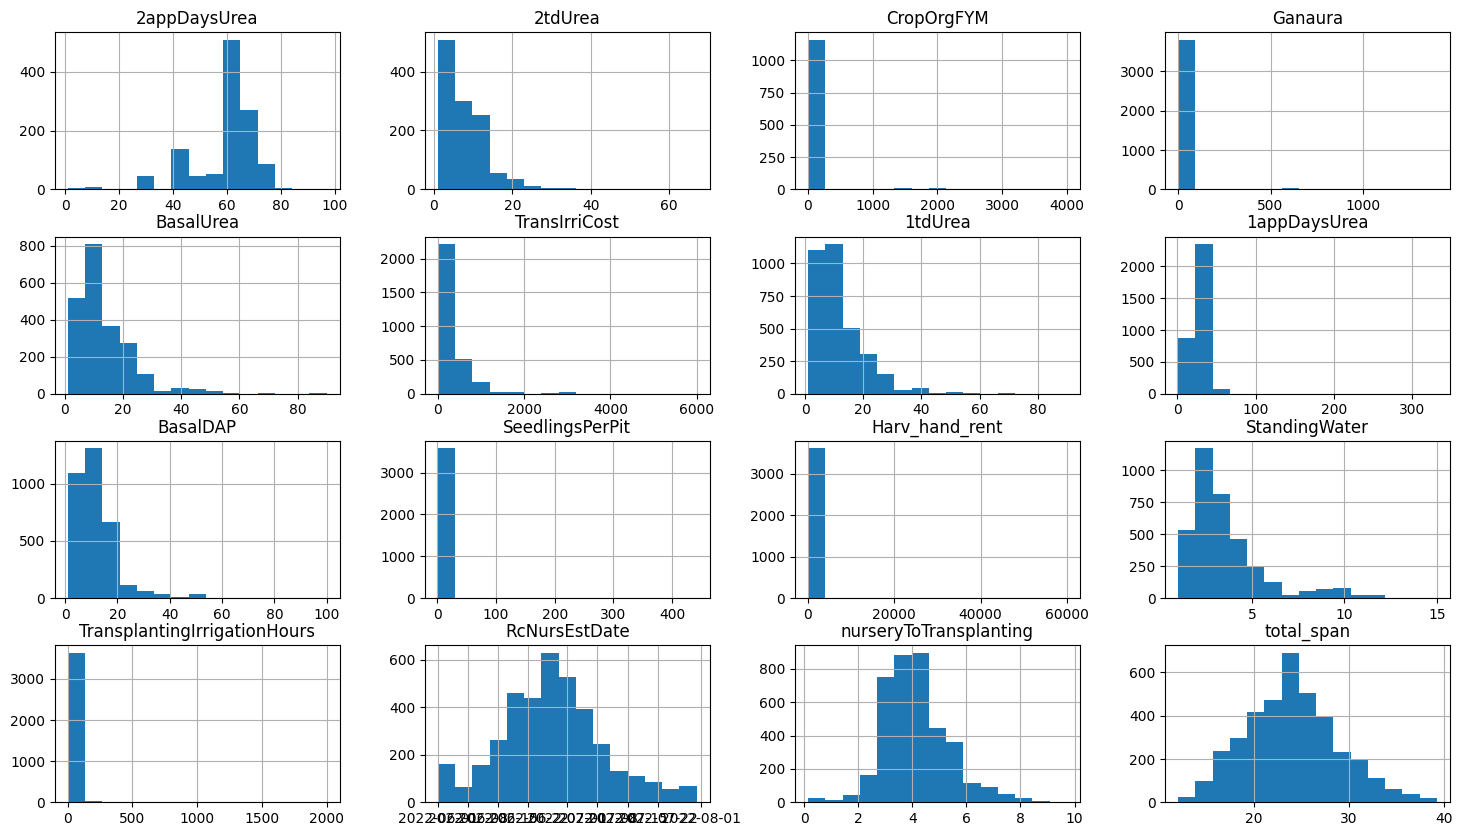

In [145]:
#Analyzing nuumerical variable
train[missing_columns].hist(bins=15, figsize=(18, 10));

__Observation__ : use mode everywhere


In [146]:
for col in missing_columns:
    train[col].fillna(train[col].mode().iloc[0], inplace = True)

In [147]:
#train.to_excel('feature.xlsx', index = False)

In [37]:
#train = train[['District', 'Block', 'CropCultLand', 'LandPreparationMethod',
 'CropEstMethod', 'SeedlingsPerPit', 'NursDetFactor', 'TransDetFactor',
 'TransplantingIrrigationHours', 'StandingWater',
 'Ganaura', 'CropOrgFYM', 'PCropSolidOrgFertAppMethod',
 'NoFertilizerAppln', 'BasalDAP', 'BasalUrea',
 'MineralFertAppMethod', '1tdUrea', '1appDaysUrea',
 '2tdUrea', '2appDaysUrea', 'Harv_method', 'Residue_perc', 'Acre', 'Yield',
 'nurseryToTransplanting', 'TransplantingToHarvesting', 'HarvestingToThreshing', 'Ganaura_count',
 'FYM_count', 'Ghanajeevamrit_count', 'VermiCompost_count']]


IndentationError: unexpected indent (3079209462.py, line 2)

In [148]:
qualitative

['District',
 'Block',
 'CropEstMethod',
 'TransplantingIrrigationSource',
 'TransplantingIrrigationPowerSource',
 'OrgFertilizers',
 'PCropSolidOrgFertAppMethod',
 'CropbasalFerts',
 'MineralFertAppMethod',
 'FirstTopDressFert',
 'Harv_method',
 'Threshing_method',
 'Stubble_use']

# 5. Relationship with Target variable

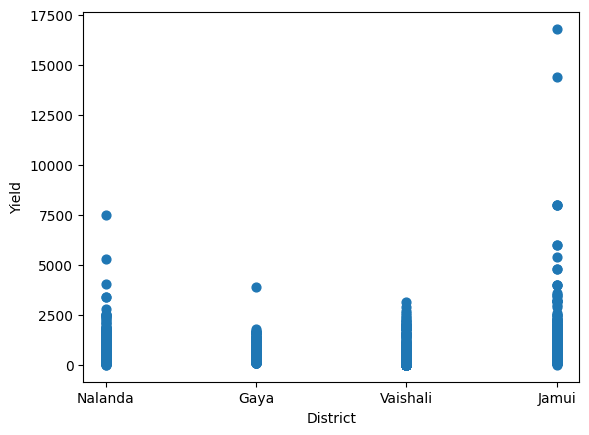

In [149]:
train.plot.scatter(x = 'District', y = 'Yield', s = 40);

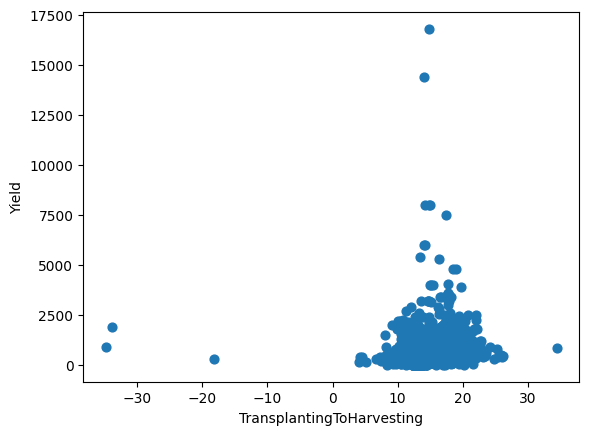

In [150]:
train.plot.scatter(x = 'TransplantingToHarvesting', y = 'Yield', s = 40);

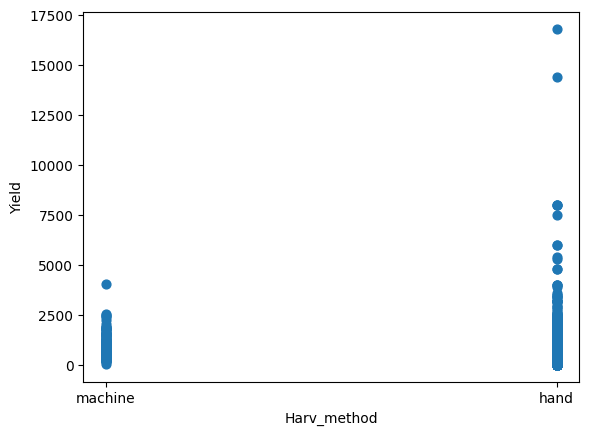

In [155]:
train.plot.scatter(x = 'Harv_method', y = 'Yield', s = 40);

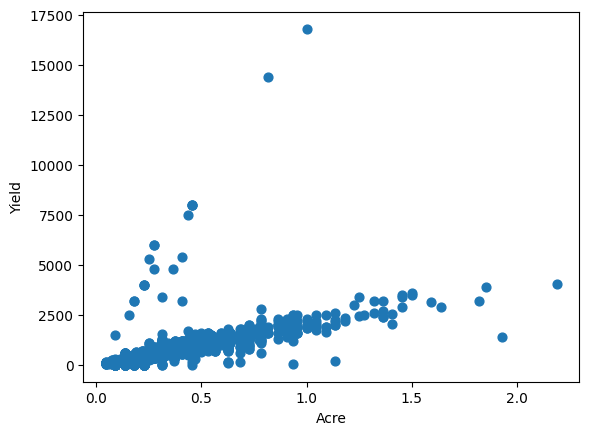

In [151]:
train.plot.scatter(x = 'Acre', y = 'Yield', s = 40);

linear relationship found

In [152]:
from sklearn.mixture import GaussianMixture

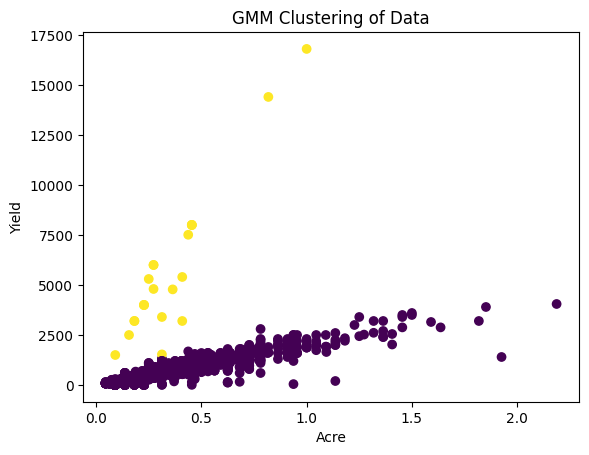

In [153]:
gmm = GaussianMixture(n_components=2, random_state=42)
train['Cluster'] = gmm.fit_predict(train[['Acre', 'Yield']])

# Scatterplot of the GMM clustered data
plt.scatter(train['Acre'], train['Yield'], c=train['Cluster'], cmap='viridis', marker='o')

plt.xlabel('Acre')
plt.ylabel('Yield')
plt.title('GMM Clustering of Data')
plt.show()

In [154]:
train['Cluster'].unique()

array([0, 1], dtype=int64)

In [77]:
# Initialize a dictionary to store regression models for each cluster
regression_models = {}

# Fit a linear regression model for each cluster
for cluster_label in train['Cluster'].unique():
    cluster_data = train[train['Cluster'] == cluster_label]
    X_cluster = cluster_data[['Acre']]
    y_cluster = cluster_data['Yield']
    
    # Fit linear regression model
    model = LinearRegression()
    model.fit(X_cluster, y_cluster)
    
    # Store the model for later use
    regression_models[cluster_label] = model

C:\Users\nabar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names

C:\Users\nabar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names



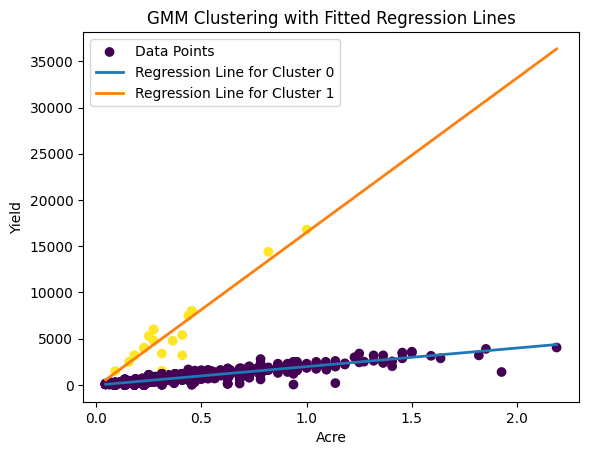

In [80]:
# Scatterplot of the clustered data
plt.scatter(train['Acre'], train['Yield'], c=train['Cluster'], cmap='viridis', marker='o', label='Data Points')

# Plot the regression lines for each cluster
for cluster_label, model in regression_models.items():
    X_cluster = np.linspace(min(train['Acre']), max(train['Acre']), 100).reshape(-1, 1)
    y_cluster_pred = model.predict(X_cluster)
    plt.plot(X_cluster, y_cluster_pred, label=f'Regression Line for Cluster {cluster_label}', linewidth=2)

plt.xlabel('Acre')
plt.ylabel('Yield')
plt.title('GMM Clustering with Fitted Regression Lines')
plt.legend()
plt.show()

In [106]:
# Function to predict 'Yield' based on 'Acre' and cluster label
def predict_yield(new_data_point):
    new_data_array = np.array([[new_data_point]])

    # Predict the cluster for the new data point
    #cluster_label = gmm.predict(new_data_array)[0]

    # Use the corresponding regression model to predict 'Yield'
    regression_model = regression_models[0]
    predicted_yield = regression_model.predict(new_data_array)[0]
    
    return predicted_yield

# Example usage for a new data point
new_data_point = 2  # Replace with your new data
predicted_yield = predict_yield(new_data_point)

print(f'Predicted Yield: {predicted_yield}')

Predicted Yield: 3994.8895485780654


C:\Users\nabar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names



In [107]:
test = pd.read_csv(data_path + '/Test.csv')
id = test.ID


In [108]:
test_scre = test['Acre'].tolist()

In [109]:
pred_test = []
for item in test_scre:
    pred_test.append(predict_yield(item))

C:\Users\nabar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names

C:\Users\nabar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names

C:\Users\nabar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names

C:\Users\nabar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names

C:\Users\nabar\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:439: UserWarning:

X does not have valid feature names, but LinearRegression was fitted with feature names

C:\Users\nabar\AppDa

In [110]:
pred_test[0]

525.377261432818

In [111]:
sub = pd.DataFrame({'ID': id, 'Yield': pred_test})
sub.to_csv('Submission_6.csv', index = False)

sub.head()

,ID,Yield
0,ID_F9XXEXN2ADR2,525.377261
1,ID_SO3VW2X4QO93,434.074307
2,ID_UKUQ7JM8E894,542.496565
3,ID_QUISMWEZR2H4,251.468397
4,ID_25JGI455VKCZ,605.267347


# Feature selection

Searching for Duplicated or Quasi-constant features

In [60]:
#Searching for Duplicated or Quasi-constant features
sel = DropConstantFeatures(tol=0.99, variables=None)

sel.fit(train)

features_to_drop = list(sel.features_to_drop_)
print(features_to_drop)

[]


In [61]:
#Looking for Correlated Features
sel = DropCorrelatedFeatures(threshold=0.80,    # more than 80% = remove
                             method='pearson') # you can use other methods like kendall or spearman

sel.fit(train)

features_to_drop = features_to_drop + list(sel.features_to_drop_)
features_to_drop = list(set(features_to_drop))
print('Features to drop', sel.features_to_drop_)
print()
print('Correlated Feature Sets', sel.correlated_feature_sets_)

Features to drop set()

Correlated Feature Sets []


In [62]:
features_to_drop = ['Stubble_use', 'PoultryManure_count', 'Jeevamrit_count', 'Pranamrit_count', 'CultLand']

In [63]:
qualitative = [item for item in qualitative if item not in features_to_drop]

In [64]:
train.drop(features_to_drop, axis=1, inplace=True)

KeyError: "['Stubble_use', 'PoultryManure_count', 'Jeevamrit_count', 'Pranamrit_count', 'CultLand'] not found in axis"

# Target Variable check

In [ ]:
# Create a histogram using Plotly Express
fig = px.histogram(train, x='Yield', nbins=30, title=f'Histogram for Yield')

# Show the plot
fig.show()

In [ ]:
train['Yield'].plot.density(color='blue')

In [ ]:
plt.figure(figsize=(10,6))
sns.distplot(train['Yield'], fit=st.norm)

In [ ]:
print(train['Yield'].skew())

In [ ]:
# Target variable is highly skewed, performing log transformation to reduce it
train['Yield_log']  = np.log(train['Yield'])  ## BETTER
train['Yield_square']  = np.sqrt(train['Yield'])
train['Yield_cube']  = np.cbrt(train['Yield'])

In [65]:
print(train['Yield'].skew())
print(train['Yield_log'].skew())
print(train['Yield_square'].skew())
print(train['Yield_cube'].skew())

9.357193094293926


KeyError: 'Yield_log'

In [66]:
plt.figure(figsize=(10,6))
sns.distplot(train['Yield_cube'], fit=st.norm)

KeyError: 'Yield_cube'

<Figure size 1000x600 with 0 Axes>

__backup__

In [67]:
train_backup = deepcopy(train)

In [120]:
# Assuming 'Yield' is your target variable
target = train['Yield']
train = train.drop(['ID', 'Yield', 'Yield_log', 'Yield_square', 'Yield_cube'], axis=1)


# Encoding

In [122]:
# Preprocess categorical columns using label encoding
label_encoders = {}
for col in qualitative:
    print(col)
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    #X_test[col] = le.transform(X_test[col])
    label_encoders[col] = le

District
Block
CropEstMethod
TransplantingIrrigationSource
TransplantingIrrigationPowerSource
OrgFertilizers
PCropSolidOrgFertAppMethod
CropbasalFerts
MineralFertAppMethod
FirstTopDressFert
Harv_method
Threshing_method


In [123]:
# Doing same for submission file
# for col, le in label_encoders.items():
#     try:
#         merged_test_data[col] = le.transform(merged_test_data[col])
#     except:
#         le2 = LabelEncoder()
#         merged_test_data[col] = le2.fit_transform(merged_test_data[col])

# Scaling

In [ ]:
train.describe().T

In [124]:
from sklearn.preprocessing import StandardScaler
col_scale = ['CropCultLand', 'SeedlingsPerPit', 'NursDetFactor', 'TransDetFactor', 'TransplantingIrrigationHours',
             'TransIrriCost', 'Ganaura', 'CropOrgFYM',
 '2appDaysUrea', 'Residue_perc', 'nurseryToTransplanting']
# Initialize the StandardScaler
scaler = StandardScaler()
for col in train.columns:
    if col in col_scale :
        train[col] = scaler.fit_transform(train[[col]])

# Model

In [125]:
train.drop(['CropTillageDate', 'RcNursEstDate','SeedingSowingTransplanting', 'Harv_date', 'Threshing_date'], axis = 1, inplace = True)

In [126]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3870 entries, 0 to 3869
Data columns (total 48 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   District                            3870 non-null   int32  
 1   Block                               3870 non-null   int32  
 2   CropCultLand                        3870 non-null   float64
 3   LandPreparationMethod               3870 non-null   int64  
 4   CropTillageDepth                    3870 non-null   int64  
 5   CropEstMethod                       3870 non-null   int32  
 6   SeedlingsPerPit                     3870 non-null   float64
 7   NursDetFactor                       3870 non-null   float64
 8   TransDetFactor                      3870 non-null   float64
 9   TransplantingIrrigationHours        3870 non-null   float64
 10  TransplantingIrrigationSource       3870 non-null   int32  
 11  TransplantingIrrigationPowerSource  3870 no

In [59]:
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size = 0.25, random_state = 1234)

NameError: name 'target' is not defined

In [128]:
import pandas as pd
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
# Create a LassoCV model that performs cross-validated L1 regularization
lasso = LassoCV(cv=10)

# Fit the model to your data
lasso.fit(X_train, y_train)

# Get the selected features and their coefficients
selected_features = X_train.columns[lasso.coef_ != 0]
lasso_coefs = lasso.coef_[lasso.coef_ != 0]

# Print or visualize the selected features and their coefficients
print("Selected Features:", selected_features)
print("Coefficients:", lasso_coefs)

Selected Features: Index(['District', 'CropbasalFerts', 'BasalDAP', 'BasalUrea', '1tdUrea',
       '2tdUrea', 'Harv_hand_rent', 'Residue_length',
       'TransplantingToHarvesting', 'total_span', 'day_of_year'],
      dtype='object')
Coefficients: [-0.0367521   0.00679104  0.08304678  0.00572867  0.0626115   0.0571389
  0.00014411 -0.05926055  0.02953533  0.0448312   0.02873289]


# xgboost

In [131]:
xgb_r = xg.XGBRegressor(tree_method="hist", eval_metric=mean_squared_error)

In [133]:
# Fitting the model
xgb_r.fit(X_train, y_train,eval_set=[(X_test, y_test)],verbose = False)
  
# Predict the model
y_pred = xgb_r.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 1.1343303768819712


In [135]:
mean_squared_error(y_test, y_pred, squared=False)

1.0650494715655097

# catboost

In [57]:
# Identify categorical columns
categorical_columns = ['District', 'Block', 'LandPreparationMethod', 'CropEstMethod', 'PCropSolidOrgFertAppMethod',
 'MineralFertAppMethod', 'Harv_method']
qualitative = [item for item in qualitative if item not in features_to_drop]
categorical_columns = qualitative

In [58]:
# Initialize the CatBoost Regressor
catboost_model = CatBoostRegressor(iterations=1000, depth=10, learning_rate=0.02, loss_function='RMSE', random_state = 12)
# Fit the model with categorical features specified
catboost_model.fit(X_train.fillna(0), y_train, cat_features=categorical_columns, eval_set=(X_test, y_test), verbose=100)
# Make predictions
preds = catboost_model.predict(X_test.fillna(0))
# Measure model performance
mean_squared_error(y_test, preds, squared=False)
mean_squared_error

NameError: name 'X_train' is not defined

In [ ]:
mean_squared_error(y_test, preds, squared=False)

In [ ]:
mean_squared_error(y_test, preds, squared=False)

In [ ]:
X_train.columns[0]

In [ ]:
# Get feature importances
feature_importance = catboost_model.feature_importances_
# Create a DataFrame with feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importance})
# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
# Plot the feature importances
plt.figure(figsize=(10, 10))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()


In [ ]:
# Split data for training and local testing

#X = train.drop(['ID', 'Yield'], axis = 1)
X = X.select_dtypes(include=np.number)
y = train.Yield

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1234)

# Instantiate model
model = RandomForestRegressor(random_state = 1234)

# Fit model
model.fit(X_train.fillna(0), y_train)

# Make predictions
preds = model.predict(X_test.fillna(0))

# Measure model performance
mean_squared_error(y_test, preds, squared=False)

# submission

In [138]:
test = pd.read_csv(data_path + '/Test.csv')
id = test.ID

In [139]:
test = test.drop(columns=['MineralFertAppMethod.1'])
test['SeedingSowingTransplanting'] = pd.to_datetime(test['SeedingSowingTransplanting'])
test['RcNursEstDate'] = pd.to_datetime(test['RcNursEstDate'])
test['Harv_date'] = pd.to_datetime(test['Harv_date'])
test['Threshing_date'] = pd.to_datetime(test['Threshing_date'])
test['nurseryToTransplanting'] = (test['SeedingSowingTransplanting'] - test['RcNursEstDate']).dt.days/ 7
test['TransplantingToHarvesting'] = (test['Harv_date'] - test['SeedingSowingTransplanting']).dt.days/ 7
test['HarvestingToThreshing'] = (test['Threshing_date'] - test['Harv_date']).dt.days/ 7

test['total_span'] = test['nurseryToTransplanting'] + test['TransplantingToHarvesting'] + test['HarvestingToThreshing']

test['CropTillageDate'] = pd.to_datetime(test['CropTillageDate'])
test['day_of_year'] = [i.dayofyear for i in test.CropTillageDate]

test['LandPreparationMethod'] = test['LandPreparationMethod'].str.split().apply(lambda x: len(x))
test['NursDetFactor'] = test['NursDetFactor'].str.split().apply(lambda x: len(str(x)))
test['TransDetFactor'] = test['TransDetFactor'].str.split().apply(lambda x: len(str(x)))

In [140]:
for fertilizer in fertilizer_list:
    test[f'{fertilizer}_count'] = test['OrgFertilizers'].apply(lambda x: str(x).split().count(fertilizer))
 
 
for fertilizer in fertilizer_list_2:
    test[f'{fertilizer}_count'] = test['CropbasalFerts'].apply(lambda x: str(x).split().count(fertilizer))

In [141]:
test['nurseryToTransplanting'].fillna(test['nurseryToTransplanting'].mean(), inplace=True)


test['PCropSolidOrgFertAppMethod'].fillna(test['PCropSolidOrgFertAppMethod'].mode().iloc[0], inplace = True)

test['Ganaura'].fillna(0, inplace = True)

for col in missing_columns:
    test[col].fillna(test[col].mode().iloc[0], inplace = True)

In [142]:
test.drop(features_to_drop, axis=1, inplace=True)

In [143]:
test = test.drop(['ID'], axis=1)

In [144]:
# Doing same for submission file
for col, le in label_encoders.items():
    try:
        test[col] = le.transform(test[col])
    except:
        le2 = LabelEncoder()
        test[col] = le2.fit_transform(test[col])

In [146]:
for col in test.columns:
    if col in ['CropOrgFYM', 'BasalDAP', 'BasalUrea', '1tdUrea', '1appDaysUrea', '2tdUrea',
 '2appDaysUrea', 'Residue_perc', 'nurseryToTransplanting'] :
        test[col] = scaler.fit_transform(test[[col]])
        #test[col] = scaler.transform(test[[col]])

In [147]:
test.drop(['CropTillageDate', 'RcNursEstDate','SeedingSowingTransplanting', 'Harv_date', 'Threshing_date'], axis = 1, inplace = True)

In [149]:
preds = xgb_r.predict(test.fillna(0))

# Create submisiion file to be uploaded to Zindi for scoring
sub = pd.DataFrame({'ID': id, 'Yield': preds})
sub['Yield'] = sub['Yield'] ** 3
sub.to_csv('Submission_4.csv', index = False)

sub.head()

,ID,Yield
0,ID_F9XXEXN2ADR2,992.209167
1,ID_SO3VW2X4QO93,1368.769653
2,ID_UKUQ7JM8E894,4124.648438
3,ID_QUISMWEZR2H4,436.047302
4,ID_25JGI455VKCZ,1076.911011
